# <center>Discriminative Regularize Generative Model for CIFAR10 </center>

## Load Data

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
#Set random seed 
torch.manual_seed(512)

In [3]:
# Pre-trained VGG19 model
import torchvision.models as models
vgg19 = models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/alfredo/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [05:21<00:00, 1788958.50it/s]


In [ ]:
#get output of specified layer in vgg16
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple


class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = list(vgg16(pretrained=True).features)[:23]
        # features的第3，8，15，22层分别是: relu1_2,relu2_2,relu3_3,relu4_3
        self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        results = []
        for ii, model in enumerate(self.features):
            x = model(x)
            if ii in {3, 8, 15, 22}:
                results.append(x)

        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        return vgg_outputs(*results)

In [3]:
#Get the CIFAR10 train images 
cifar = datasets.CIFAR10('./data/cifar/', train = True, download = True)

In [4]:
#Convert the numpy tensor into a PyTorch one 
x = torch.from_numpy( cifar.train_data ).transpose(1,3).transpose(2,3)

In [5]:
#Check characteristics of data 
print(str(type(x)),x.size(), x.min(), x.max())

<class 'torch.Tensor'> torch.Size([50000, 3, 32, 32]) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


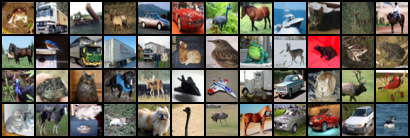

In [6]:
#Check data
check = x.narrow(0,0,48).float().div(255)
title = 'images-cifar-4x12.png'
torchvision.utils.save_image(check,title,nrow=12)
Image(title)

In [7]:
x.size()

torch.Size([50000, 3, 32, 32])

In [8]:
# Organize training data in batches, 
# normalize them to have values between [-1, 1] (?)

train_images = torch.utils.data.DataLoader ( datasets.CIFAR10('./data/cifar/', train = True, download=False,
                               transform=transforms.Compose([
                               #transforms.Resize(64), 
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.ToTensor(),])) , 
                               batch_size = 128, shuffle = True)

In [9]:
for batch_idx, (data,_) in enumerate(train_images):
    print(data.size())
    print(data[0])
    break

torch.Size([128, 3, 32, 32])
tensor([[[ 0.5412,  0.5412,  0.5569,  ...,  0.3608,  0.3529,  0.2863],
         [ 0.5412,  0.5373,  0.5451,  ...,  0.4078,  0.3608,  0.2745],
         [ 0.5137,  0.5216,  0.5490,  ...,  0.3725,  0.3843,  0.3137],
         ...,
         [ 0.6431,  0.6431,  0.6431,  ...,  0.5922,  0.5843,  0.5804],
         [ 0.6549,  0.6471,  0.6431,  ...,  0.5961,  0.5882,  0.5843],
         [ 0.6588,  0.6627,  0.6471,  ...,  0.6039,  0.5961,  0.5922]],

        [[ 0.4510,  0.4471,  0.4588,  ...,  0.1490,  0.1529,  0.2863],
         [ 0.4510,  0.4510,  0.4510,  ...,  0.1922,  0.1569,  0.2549],
         [ 0.4275,  0.4353,  0.4549,  ...,  0.2078,  0.1804,  0.1765],
         ...,
         [ 0.6118,  0.6118,  0.6039,  ...,  0.5333,  0.5294,  0.5255],
         [ 0.6196,  0.6157,  0.6078,  ...,  0.5412,  0.5333,  0.5333],
         [ 0.6235,  0.6196,  0.6118,  ...,  0.5529,  0.5451,  0.5412]],

        [[ 0.3608,  0.3451,  0.3608,  ...,  0.0824,  0.1255,  0.2314],
         [ 0.356

## Model

We will use the arquitecture suggested by [Radford et al](https://arxiv.org/abs/1511.06434) for both the encoder and decoder. With convolutional layers in the encoder and fractionally-strided  convolutions  in  the  decoder.   In  each convolutional layer in the encoder we double the number of filters present in the previous layer and use a convolutional stride of 2.  In each convolutional layer in the decoder we use a fractional stride of 2 and halve the number of filters on each layer.

In [10]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

class VAE( nn.Module ):

    def __init__ ( self, image_size ,  hidden_dim , encoding_dim ):
        
        super( VAE, self ).__init__()
        
        self.encoding_dim = encoding_dim
        self.image_size = image_size
        self.hidden_dim = hidden_dim 
        
        # Decoder - Fractional strided convolutional layers
        self.decoder  = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False),
            nn.Sigmoid() # nn.Tanh()  
        )
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(32, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 0, bias = False),
            nn.Sigmoid()
        )
        
        # Fully-connected layers
        self.fc1 = nn.Linear(256, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.encoding_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.encoding_dim)
        self.fc3 = nn.Linear(self.encoding_dim, self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, 256)
    
    def decode (self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.sigmoid(self.fc4(h3))
        return self.decoder( h4.view(z.size(0),-1,1,1) ) 

        
    def forward(self, x):
        
        # Encode 
        encoded = F.relu(self.fc1( self.encoder(x).view(x.size(0), -1) ) )
        
        #Obtain mu and logvar
        mu = self.fc21( encoded )
        logvar = self.fc22 ( encoded )
        
        #Reparametrization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        
        # Decode 
        decoded = self.decode(z)

        # return decoded, mu, logvar
        return decoded, mu , logvar

    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [12]:
#Define model
model = VAE( 32, 100, 20 )
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Train model
def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_images):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_images.dataset),
                100. * batch_idx / len(train_images),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_images.dataset)))

In [13]:
num_epochs = 30
for epoch in range(1,num_epochs):
    train(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20)
        sample = model.decode(sample)
        torchvision.utils.save_image(sample.view(64, 3, 32, 32),'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2132.287109
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2054.959229
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2013.100464
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2012.081665
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1980.499146
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1994.128296
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1960.671387
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1987.776245
====> Epoch: 1 Average loss: 2007.1042
Train Epoch: 2 [0/50000 (0%)]	Loss: 1960.549683
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1957.774048
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1955.388184
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1979.469238
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1995.364990
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1930.115845
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1966.103149
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1973.310425
====> Epoch: 2 Average loss: 1960.4878
Train Epoch: 3 [0/50000 (0%)]	Loss: 1966.006958
Train Epoch: 3 [6400/50000 (13%)]	Loss

Train Epoch: 18 [44800/50000 (90%)]	Loss: 1889.099121
====> Epoch: 18 Average loss: 1875.5207
Train Epoch: 19 [0/50000 (0%)]	Loss: 1882.168335
Train Epoch: 19 [6400/50000 (13%)]	Loss: 1897.403809
Train Epoch: 19 [12800/50000 (26%)]	Loss: 1867.750854
Train Epoch: 19 [19200/50000 (38%)]	Loss: 1873.920410
Train Epoch: 19 [25600/50000 (51%)]	Loss: 1875.597900
Train Epoch: 19 [32000/50000 (64%)]	Loss: 1863.678589
Train Epoch: 19 [38400/50000 (77%)]	Loss: 1887.318970
Train Epoch: 19 [44800/50000 (90%)]	Loss: 1846.239502
====> Epoch: 19 Average loss: 1872.9162
Train Epoch: 20 [0/50000 (0%)]	Loss: 1869.874146
Train Epoch: 20 [6400/50000 (13%)]	Loss: 1877.944214
Train Epoch: 20 [12800/50000 (26%)]	Loss: 1870.107422
Train Epoch: 20 [19200/50000 (38%)]	Loss: 1897.449707
Train Epoch: 20 [25600/50000 (51%)]	Loss: 1885.085083
Train Epoch: 20 [32000/50000 (64%)]	Loss: 1893.617554
Train Epoch: 20 [38400/50000 (77%)]	Loss: 1870.250488
Train Epoch: 20 [44800/50000 (90%)]	Loss: 1862.607544
====> Epoch: 2

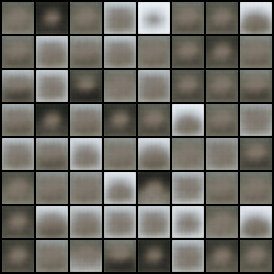

In [3]:
Image('results/sample_1.png') ## Epoch 1

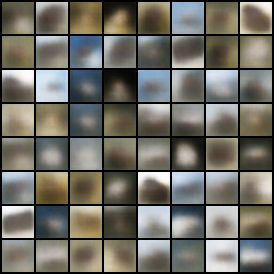

In [4]:
Image('results/sample_10.png') ## Epoch 10

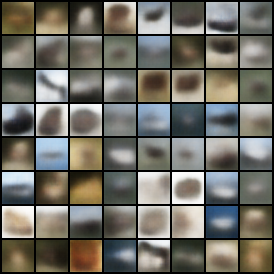

In [5]:
Image('results/sample_29.png') ## Epoch 29